TREASURY FUTURES STRATEGY BACKTEST

Configuration:
  Date Range: 2015-12-12 to 2025-12-09
  Total Exposure: $200mm
  Tiered MA Allocation: 50% ($100.0mm)
  MonthEnd Allocation: 50% ($100.0mm)

STEP 1: DATA ACQUISITION

Fetching TY1 Comdty (10Y Treasury Futures)...
  ✓ TY data: 2516 observations
  ✓ Date range: 2015-12-14 to 2025-12-09

Fetching SPX Index (for correlation filter)...
  ✓ SPX data: 2512 observations

  Combined dataset: 2516 observations
  Missing values: 0

STEP 2: CALCULATING INDICATORS
  ✓ Moving averages calculated (20, 50, 200-day)
  ✓ TY/SPX correlation calculated (20-day rolling)
  ✓ Clean data: 2317 observations (after removing NaN)

STEP 3: GENERATING STRATEGY SIGNALS

Tiered MA Cross 20/50...
  ✓ Tiered signals generated
    Both filters: 1281 days
    One filter:   945 days
    No filters:   91 days
    Only Filter #8: 757 days
    Only Filter #19: 188 days

Month-End Long/Short...
  ✓ MonthEnd signals generated
    Long days:  552
    Short days: 555
    Flat 

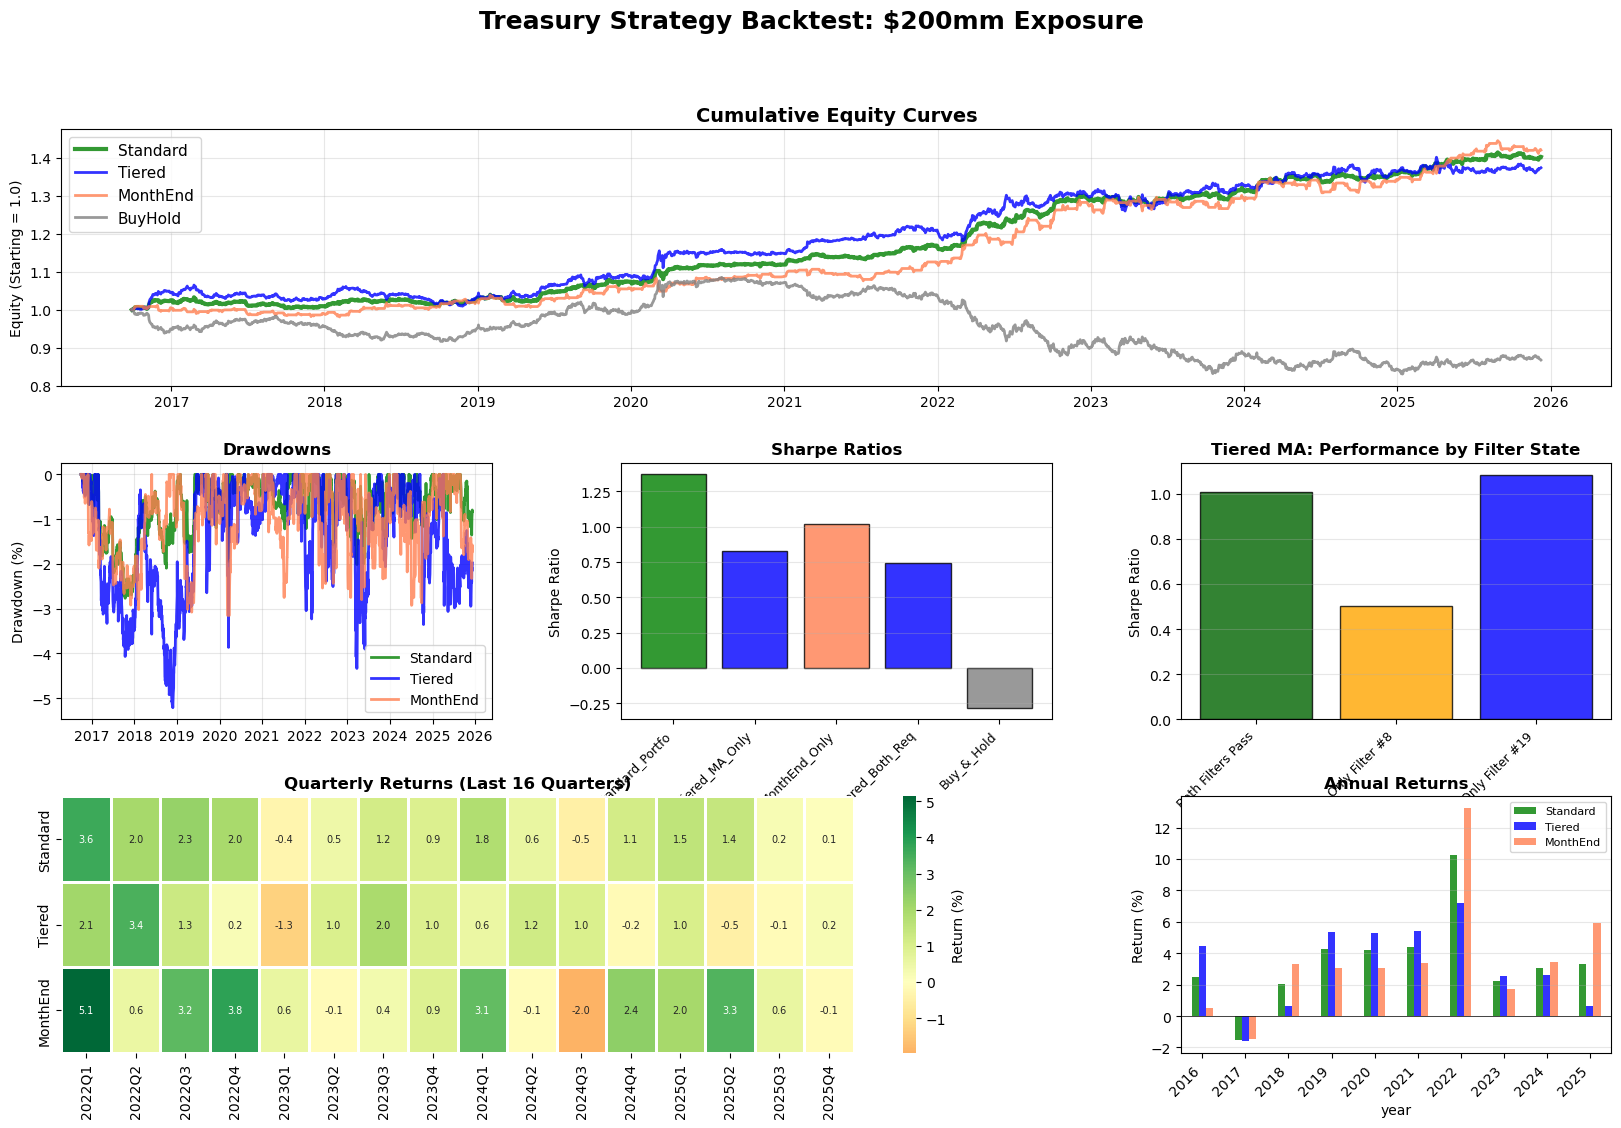

In [4]:
"""
TREASURY FUTURES STRATEGY - STANDALONE BACKTEST MODULE - MONTH END IS LAGGED BY A DAY
=====================================================

Standard Portfolio: 50% Tiered MA Cross + 50% Month-End Long/Short
Total Exposure: $200mm (configurable)

Author: Quantitative Research Team
Date: December 2025
"""

import pandas as pd
import numpy as np
from xbbg import blp
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Date range
YEARS_BACK = 10  # Default: 10 years of history
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=365 * YEARS_BACK)

# Exposure and allocation
TOTAL_EXPOSURE_MM = 200  # Total portfolio exposure in $mm
TIERED_ALLOCATION = 0.50  # 50% to Tiered MA, 50% to MonthEnd
MONTHEND_ALLOCATION = 1.0 - TIERED_ALLOCATION

# Derived allocations
TIERED_BASE_MM = TOTAL_EXPOSURE_MM * TIERED_ALLOCATION
MONTHEND_BASE_MM = TOTAL_EXPOSURE_MM * MONTHEND_ALLOCATION

print("="*80)
print("TREASURY FUTURES STRATEGY BACKTEST")
print("="*80)
print(f"\nConfiguration:")
print(f"  Date Range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"  Total Exposure: ${TOTAL_EXPOSURE_MM}mm")
print(f"  Tiered MA Allocation: {TIERED_ALLOCATION*100:.0f}% (${TIERED_BASE_MM}mm)")
print(f"  MonthEnd Allocation: {MONTHEND_ALLOCATION*100:.0f}% (${MONTHEND_BASE_MM}mm)")

# ============================================================================
# STEP 1: DATA ACQUISITION
# ============================================================================
print("\n" + "="*80)
print("STEP 1: DATA ACQUISITION")
print("="*80)

print("\nFetching TY1 Comdty (10Y Treasury Futures)...")

try:
    ty_data = blp.bdh(
        tickers='TY1 Comdty',
        flds=['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'PX_VOLUME'],
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    ty_data.columns = ['_'.join(col).strip() for col in ty_data.columns.values]
    ty_data.columns = ['open', 'high', 'low', 'close', 'volume']
    
    print(f"  ✓ TY data: {len(ty_data)} observations")
    print(f"  ✓ Date range: {ty_data.index[0]} to {ty_data.index[-1]}")
    
except Exception as e:
    print(f"  ✗ Error: {e}")
    raise

print("\nFetching SPX Index (for correlation filter)...")

try:
    spx_data = blp.bdh(
        tickers='SPX Index',
        flds='PX_LAST',
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    spx_data.columns = ['spx_close']
    
    print(f"  ✓ SPX data: {len(spx_data)} observations")
    
except Exception as e:
    print(f"  ✗ Error: {e}")
    raise

# Merge data
data = pd.concat([ty_data, spx_data], axis=1).fillna(method='ffill')

print(f"\n  Combined dataset: {len(data)} observations")
print(f"  Missing values: {data.isnull().sum().sum()}")

# ============================================================================
# STEP 2: CALCULATE INDICATORS
# ============================================================================
print("\n" + "="*80)
print("STEP 2: CALCULATING INDICATORS")
print("="*80)

# Price and returns
data['price'] = data['close']
data['returns'] = data['price'].pct_change()

# Moving averages
data['ma_20'] = data['price'].rolling(20).mean()
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()

# SPX returns and correlation
data['spx_returns'] = data['spx_close'].pct_change()
data['ty_spx_corr_20d'] = data['returns'].rolling(20).corr(data['spx_returns'])

print(f"  ✓ Moving averages calculated (20, 50, 200-day)")
print(f"  ✓ TY/SPX correlation calculated (20-day rolling)")

# Clean data
data_clean = data.dropna()
print(f"  ✓ Clean data: {len(data_clean)} observations (after removing NaN)")

# ============================================================================
# STEP 3: STRATEGY SIGNALS
# ============================================================================
print("\n" + "="*80)
print("STEP 3: GENERATING STRATEGY SIGNALS")
print("="*80)

# === TIERED MA CROSS ===
print("\nTiered MA Cross 20/50...")

# Base direction
signal_ma_direction = pd.Series(0, index=data_clean.index)
signal_ma_direction[data_clean['ma_20'] > data_clean['ma_50']] = 1  # Bullish
signal_ma_direction[data_clean['ma_20'] < data_clean['ma_50']] = -1  # Bearish

# Filter conditions
filter_8 = (abs(data_clean['price'] - data_clean['ma_20']) / data_clean['price']) >= 0.001
filter_19 = data_clean['ty_spx_corr_20d'] <= 0

# Tiered exposure (in $mm)
tiered_exposure_mm = pd.Series(0.0, index=data_clean.index)

both_pass = filter_8 & filter_19
one_passes = (filter_8 & ~filter_19) | (~filter_8 & filter_19)
neither_pass = ~filter_8 & ~filter_19

tiered_exposure_mm[both_pass] = TIERED_BASE_MM * 1.0  # 100% of allocation
tiered_exposure_mm[one_passes] = TIERED_BASE_MM * 0.5  # 50% of allocation
tiered_exposure_mm[neither_pass] = 0.0  # 0% of allocation

# Apply direction
tiered_exposure_mm = tiered_exposure_mm * signal_ma_direction

# Alternative: Both filters required
tiered_exposure_both_required = pd.Series(0.0, index=data_clean.index)
tiered_exposure_both_required[both_pass] = TIERED_BASE_MM * signal_ma_direction[both_pass]

print(f"  ✓ Tiered signals generated")
print(f"    Both filters: {both_pass.sum()} days")
print(f"    One filter:   {one_passes.sum()} days")
print(f"    No filters:   {neither_pass.sum()} days")

# Breakdown by individual filter
only_8 = filter_8 & ~filter_19
only_19 = ~filter_8 & filter_19

print(f"    Only Filter #8: {only_8.sum()} days")
print(f"    Only Filter #19: {only_19.sum()} days")

# === MONTH-END LONG/SHORT ===
print("\nMonth-End Long/Short...")

def create_month_end_exposure(dates, base_mm):
    """Create month-end exposure in $mm"""
    # Ensure dates is DatetimeIndex
    if not isinstance(dates, pd.DatetimeIndex):
        dates = pd.DatetimeIndex(dates)
    
    df = pd.DataFrame({'date': dates, 'ym': dates.to_period('M')})
    exposure = pd.Series(0.0, index=dates)
    
    for ym in df['ym'].unique():
        month_mask = df['ym'] == ym
        month_idx = df[month_mask].index
        
        if len(month_idx) >= 5:
            # Long last 5 days
            exposure.iloc[month_idx[-5:]] = base_mm
            # Short first 5 days
            exposure.iloc[month_idx[:5]] = -base_mm
    
    return exposure

monthend_exposure_mm = create_month_end_exposure(data_clean.index, MONTHEND_BASE_MM)

long_days = (monthend_exposure_mm > 0).sum()
short_days = (monthend_exposure_mm < 0).sum()
flat_days = (monthend_exposure_mm == 0).sum()

print(f"  ✓ MonthEnd signals generated")
print(f"    Long days:  {long_days}")
print(f"    Short days: {short_days}")
print(f"    Flat days:  {flat_days}")

# === BUY & HOLD BENCHMARK ===
buyhold_exposure_mm = pd.Series(TOTAL_EXPOSURE_MM, index=data_clean.index)

print(f"\n  ✓ Buy & Hold benchmark (${TOTAL_EXPOSURE_MM}mm always long)")

print("\n" + "="*80)
print("Ready for Step 4: Return Calculation")
print("="*80)

print("\nSignals generated for:")
print("  - Standard Portfolio (Tiered + MonthEnd)")
print("  - Tiered MA only (with filter analysis)")
print("  - Tiered Both-Required (stricter version)")
print("  - MonthEnd only")
print("  - Buy & Hold benchmark")

# ============================================================================
# STEP 4: CALCULATE DOLLAR P&L
# ============================================================================
print("\n" + "="*80)
print("STEP 4: CALCULATING DOLLAR P&L")
print("="*80)

# Standard Portfolio
standard_exposure = tiered_exposure_mm + monthend_exposure_mm
standard_pnl_daily = standard_exposure.shift(1) * data_clean['returns']

# Individual components
tiered_pnl_daily = tiered_exposure_mm.shift(1) * data_clean['returns']
monthend_pnl_daily = monthend_exposure_mm.shift(1) * data_clean['returns']

# Tiered Both-Required variant
tiered_both_pnl_daily = tiered_exposure_both_required.shift(1) * data_clean['returns']

# Buy & Hold
buyhold_pnl_daily = buyhold_exposure_mm.shift(1) * data_clean['returns']

print("  ✓ Standard Portfolio P&L calculated")
print("  ✓ Component P&Ls calculated")
print("  ✓ Buy & Hold P&L calculated")

# Convert to percentage returns on total exposure
standard_returns = standard_pnl_daily / TOTAL_EXPOSURE_MM
tiered_returns = tiered_pnl_daily / TIERED_BASE_MM
monthend_returns = monthend_pnl_daily / MONTHEND_BASE_MM
tiered_both_returns = tiered_both_pnl_daily / TIERED_BASE_MM
buyhold_returns = buyhold_pnl_daily / TOTAL_EXPOSURE_MM

# ============================================================================
# STEP 5: BUILD AUDIT DATAFRAME
# ============================================================================
print("\n" + "="*80)
print("STEP 5: BUILDING COMPREHENSIVE AUDIT TRAIL")
print("="*80)

audit = pd.DataFrame(index=data_clean.index)

# Market data
audit['Date'] = audit.index
audit['TY_Close'] = data_clean['price']
audit['TY_Return_%'] = data_clean['returns'] * 100
audit['MA_20'] = data_clean['ma_20']
audit['MA_50'] = data_clean['ma_50']
audit['MA_200'] = data_clean['ma_200']
audit['SPX_Close'] = data_clean['spx_close']
audit['TY_SPX_Corr_20d'] = data_clean['ty_spx_corr_20d']

# Filter states
audit['Filter_8_Pass'] = filter_8.astype(int)
audit['Filter_19_Pass'] = filter_19.astype(int)
audit['Filters_Count'] = filter_8.astype(int) + filter_19.astype(int)

# Tiered signals
audit['Tiered_Direction'] = signal_ma_direction
audit['Tiered_Exposure_$mm'] = tiered_exposure_mm
audit['Tiered_PnL_$mm'] = tiered_pnl_daily
audit['Tiered_Return_%'] = tiered_returns * 100

# MonthEnd signals
audit['MonthEnd_Exposure_$mm'] = monthend_exposure_mm
audit['MonthEnd_PnL_$mm'] = monthend_pnl_daily
audit['MonthEnd_Return_%'] = monthend_returns * 100

# Standard Portfolio
audit['Standard_Exposure_$mm'] = standard_exposure
audit['Standard_PnL_$mm'] = standard_pnl_daily
audit['Standard_Return_%'] = standard_returns * 100

# Cumulative metrics
audit['Standard_Equity'] = (1 + standard_returns).cumprod()
audit['Tiered_Equity'] = (1 + tiered_returns).cumprod()
audit['MonthEnd_Equity'] = (1 + monthend_returns).cumprod()
audit['BuyHold_Equity'] = (1 + buyhold_returns).cumprod()

# Drawdowns
for strat in ['Standard', 'Tiered', 'MonthEnd', 'BuyHold']:
    cum = audit[f'{strat}_Equity']
    dd = (cum - cum.expanding().max()) / cum.expanding().max()
    audit[f'{strat}_DD_%'] = dd * 100

print(f"  ✓ Audit trail created: {audit.shape[0]} rows × {audit.shape[1]} columns")

# ============================================================================
# STEP 6: FILTER STATE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STEP 6: TIERED MA FILTER STATE ANALYSIS")
print("="*80)

def analyze_filter_state(condition, state_name):
    """Analyze performance in specific filter state"""
    # Shift and fill NaN to avoid indexing issues
    condition_shifted = condition.shift(1).fillna(False)
    state_returns = tiered_returns[condition_shifted]
    
    if len(state_returns) == 0:
        return None
    
    days = condition.sum()
    ann_ret = state_returns.mean() * 252
    ann_vol = state_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    win_rate = (state_returns > 0).sum() / len(state_returns)
    
    return {
        'State': state_name,
        'Days': days,
        'Pct_Days': days / len(condition) * 100,
        'Ann_Return_%': ann_ret * 100,
        'Ann_Vol_%': ann_vol * 100,
        'Sharpe': sharpe,
        'Win_Rate_%': win_rate * 100
    }

filter_states = [
    (both_pass, 'Both Filters Pass'),
    (only_8, 'Only Filter #8'),
    (only_19, 'Only Filter #19'),
    (neither_pass, 'Neither Pass')
]

filter_analysis = []
for condition, name in filter_states:
    result = analyze_filter_state(condition, name)
    if result:
        filter_analysis.append(result)

filter_df = pd.DataFrame(filter_analysis)

print(f"\n{'Filter State':<20s} {'Days':>6s} {'%Days':>7s} {'AnnRet':>8s} {'AnnVol':>8s} {'Sharpe':>7s} {'WinRate':>8s}")
print("-"*80)

for _, row in filter_df.iterrows():
    print(f"{row['State']:<20s} {row['Days']:>6.0f} {row['Pct_Days']:>6.1f}% "
          f"{row['Ann_Return_%']:>7.2f}% {row['Ann_Vol_%']:>7.2f}% "
          f"{row['Sharpe']:>7.2f} {row['Win_Rate_%']:>7.1f}%")

# ============================================================================
# STEP 7: AGGREGATE TO MONTHLY/QUARTERLY/ANNUAL
# ============================================================================
print("\n" + "="*80)
print("STEP 7: AGGREGATING PERFORMANCE PERIODS")
print("="*80)

def calc_period_aggregates(returns_series, period_type='M'):
    """Aggregate daily returns to monthly/quarterly/annual"""
    # Ensure index is DatetimeIndex
    if not isinstance(returns_series.index, pd.DatetimeIndex):
        returns_series.index = pd.DatetimeIndex(returns_series.index)
    
    df = pd.DataFrame({'ret': returns_series})
    df['year'] = returns_series.index.year
    
    if period_type == 'M':
        df['month'] = returns_series.index.month
        grouped = df.groupby(['year', 'month'])
        period_returns = grouped['ret'].apply(lambda x: (1+x).prod()-1)
        period_returns.index = pd.to_datetime([f"{y}-{m:02d}-01" for y, m in period_returns.index])
    elif period_type == 'Q':
        df['quarter'] = returns_series.index.quarter
        grouped = df.groupby(['year', 'quarter'])
        period_returns = grouped['ret'].apply(lambda x: (1+x).prod()-1)
        period_returns.index = [f"{y}Q{q}" for y, q in period_returns.index]
    else:  # Annual
        period_returns = df.groupby('year')['ret'].apply(lambda x: (1+x).prod()-1)
    
    return period_returns

# Monthly
monthly_standard = calc_period_aggregates(standard_returns, 'M')
monthly_tiered = calc_period_aggregates(tiered_returns, 'M')
monthly_monthend = calc_period_aggregates(monthend_returns, 'M')
monthly_tiered_both = calc_period_aggregates(tiered_both_returns, 'M')
monthly_buyhold = calc_period_aggregates(buyhold_returns, 'M')

# Quarterly
quarterly_standard = calc_period_aggregates(standard_returns, 'Q')
quarterly_tiered = calc_period_aggregates(tiered_returns, 'Q')
quarterly_monthend = calc_period_aggregates(monthend_returns, 'Q')
quarterly_tiered_both = calc_period_aggregates(tiered_both_returns, 'Q')
quarterly_buyhold = calc_period_aggregates(buyhold_returns, 'Q')

# Annual
annual_standard = calc_period_aggregates(standard_returns, 'Y')
annual_tiered = calc_period_aggregates(tiered_returns, 'Y')
annual_monthend = calc_period_aggregates(monthend_returns, 'Y')
annual_tiered_both = calc_period_aggregates(tiered_both_returns, 'Y')
annual_buyhold = calc_period_aggregates(buyhold_returns, 'Y')

print(f"  ✓ Monthly returns: {len(monthly_standard)} months")
print(f"  ✓ Quarterly returns: {len(quarterly_standard)} quarters")
print(f"  ✓ Annual returns: {len(annual_standard)} years")

# ============================================================================
# STEP 8: COMPREHENSIVE PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("STEP 8: CALCULATING PERFORMANCE METRICS")
print("="*80)

def calc_comprehensive_metrics(returns_series, name, exposure_mm):
    """Calculate full suite of performance metrics"""
    ret = returns_series.dropna()
    
    # Basic returns
    total_ret = (1 + ret).prod() - 1
    years = len(ret) / 252
    ann_ret = (1 + total_ret) ** (1/years) - 1
    ann_vol = ret.std() * np.sqrt(252)
    
    # Risk-adjusted
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    downside = ret[ret < 0]
    down_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / down_vol if down_vol > 0 else 0
    
    # Drawdown
    cum = (1 + ret).cumprod()
    dd = (cum - cum.expanding().max()) / cum.expanding().max()
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    # Win metrics
    win_rate = (ret > 0).sum() / len(ret)
    avg_win = ret[ret > 0].mean() if (ret > 0).any() else 0
    avg_loss = ret[ret < 0].mean() if (ret < 0).any() else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    # Dollar metrics
    total_pnl_mm = total_ret * exposure_mm
    ann_pnl_mm = ann_ret * exposure_mm
    
    return {
        'Strategy': name,
        'Exposure_$mm': exposure_mm,
        'Total_Return_%': total_ret * 100,
        'Total_PnL_$mm': total_pnl_mm,
        'Annual_Return_%': ann_ret * 100,
        'Annual_PnL_$mm': ann_pnl_mm,
        'Annual_Vol_%': ann_vol * 100,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD_%': max_dd * 100,
        'Calmar': calmar,
        'Win_Rate_%': win_rate * 100,
        'Avg_Win_%': avg_win * 100,
        'Avg_Loss_%': avg_loss * 100,
        'Profit_Factor': profit_factor,
        'Total_Days': len(ret)
    }

metrics = [
    calc_comprehensive_metrics(standard_returns, 'Standard_Portfolio', TOTAL_EXPOSURE_MM),
    calc_comprehensive_metrics(tiered_returns, 'Tiered_MA_Only', TIERED_BASE_MM),
    calc_comprehensive_metrics(monthend_returns, 'MonthEnd_Only', MONTHEND_BASE_MM),
    calc_comprehensive_metrics(tiered_both_returns, 'Tiered_Both_Required', TIERED_BASE_MM),
    calc_comprehensive_metrics(buyhold_returns, 'Buy_&_Hold', TOTAL_EXPOSURE_MM)
]

metrics_df = pd.DataFrame(metrics)

print("\nPerformance Summary:")
print(f"\n{'Strategy':<25s} {'Sharpe':>7s} {'AnnRet':>8s} {'Ann$mm':>8s} {'MaxDD':>8s}")
print("-"*65)

for _, row in metrics_df.iterrows():
    print(f"{row['Strategy']:<25s} {row['Sharpe']:>7.2f} {row['Annual_Return_%']:>7.2f}% "
          f"${row['Annual_PnL_$mm']:>7.1f}mm {row['Max_DD_%']:>7.2f}%")

# ============================================================================
# STEP 9: EXPORT TO EXCEL
# ============================================================================
print("\n" + "="*80)
print("STEP 9: EXPORTING COMPREHENSIVE EXCEL FILE")
print("="*80)

filename = f'Treasury__20_50_MA_Month_End_Correct_Backtest_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xlsx'

with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
    
    # Sheet 1: Configuration & Documentation
    config_df = pd.DataFrame({
        'Parameter': ['Start Date', 'End Date', 'Total Exposure', 'Tiered Allocation', 
                     'MonthEnd Allocation', 'Tiered Base $mm', 'MonthEnd Base $mm'],
        'Value': [START_DATE.strftime('%Y-%m-%d'), END_DATE.strftime('%Y-%m-%d'),
                 f'${TOTAL_EXPOSURE_MM}mm', f'{TIERED_ALLOCATION*100:.0f}%',
                 f'{MONTHEND_ALLOCATION*100:.0f}%', f'${TIERED_BASE_MM}mm', f'${MONTHEND_BASE_MM}mm']
    })
    config_df.to_excel(writer, sheet_name='Configuration', index=False)
    
    # Sheet 2: Strategy Documentation
    strategy_doc = pd.DataFrame({
        'Strategy': ['Standard Portfolio', 'Tiered MA Cross', 'MonthEnd Long/Short'],
        'Description': [
            '50% Tiered MA + 50% MonthEnd - Combined portfolio',
            'MA 20/50 cross with tiered exposure: $100mm both filters, $50mm one filter, $0mm neither',
            'Long last 5 days ($100mm), Short first 5 days ($100mm)'
        ],
        'Exposure_Logic': [
            'Sum of component exposures',
            'Both filters: $100mm | One filter: $50mm | Neither: $0mm',
            'Active periods: $100mm | Inactive: $0mm'
        ]
    })
    strategy_doc.to_excel(writer, sheet_name='Strategy_Documentation', index=False)
    
    # Sheet 3: Daily Audit Trail
    audit.to_excel(writer, sheet_name='Daily_Audit_Trail', index=False)
    
    # Sheet 4: Performance Metrics
    metrics_df.to_excel(writer, sheet_name='Performance_Metrics', index=False)
    
    # Sheet 5: Filter State Analysis
    filter_df.to_excel(writer, sheet_name='Filter_State_Analysis', index=False)
    
    # Sheet 6-10: Monthly returns
    monthly_comparison = pd.DataFrame({
        'Standard_%': monthly_standard * 100,
        'Tiered_%': monthly_tiered * 100,
        'MonthEnd_%': monthly_monthend * 100,
        'Tiered_Both_%': monthly_tiered_both * 100,
        'BuyHold_%': monthly_buyhold * 100
    })
    monthly_comparison.to_excel(writer, sheet_name='Monthly_Returns')
    
    # Monthly dollar P&L
    monthly_pnl = pd.DataFrame({
        'Standard_$mm': monthly_standard * TOTAL_EXPOSURE_MM,
        'Tiered_$mm': monthly_tiered * TIERED_BASE_MM,
        'MonthEnd_$mm': monthly_monthend * MONTHEND_BASE_MM,
        'Tiered_Both_$mm': monthly_tiered_both * TIERED_BASE_MM,
        'BuyHold_$mm': monthly_buyhold * TOTAL_EXPOSURE_MM
    })
    monthly_pnl.to_excel(writer, sheet_name='Monthly_PnL_$mm')
    
    # Sheet 11-15: Quarterly
    quarterly_comparison = pd.DataFrame({
        'Standard_%': quarterly_standard * 100,
        'Tiered_%': quarterly_tiered * 100,
        'MonthEnd_%': quarterly_monthend * 100,
        'Tiered_Both_%': quarterly_tiered_both * 100,
        'BuyHold_%': quarterly_buyhold * 100
    })
    quarterly_comparison.to_excel(writer, sheet_name='Quarterly_Returns')
    
    quarterly_pnl = pd.DataFrame({
        'Standard_$mm': quarterly_standard * TOTAL_EXPOSURE_MM,
        'Tiered_$mm': quarterly_tiered * TIERED_BASE_MM,
        'MonthEnd_$mm': quarterly_monthend * MONTHEND_BASE_MM,
        'Tiered_Both_$mm': quarterly_tiered_both * TIERED_BASE_MM,
        'BuyHold_$mm': quarterly_buyhold * TOTAL_EXPOSURE_MM
    })
    quarterly_pnl.to_excel(writer, sheet_name='Quarterly_PnL_$mm')
    
    # Sheet 16-20: Annual
    annual_comparison = pd.DataFrame({
        'Standard_%': annual_standard * 100,
        'Tiered_%': annual_tiered * 100,
        'MonthEnd_%': annual_monthend * 100,
        'Tiered_Both_%': annual_tiered_both * 100,
        'BuyHold_%': annual_buyhold * 100
    })
    annual_comparison.to_excel(writer, sheet_name='Annual_Returns')
    
    annual_pnl = pd.DataFrame({
        'Standard_$mm': annual_standard * TOTAL_EXPOSURE_MM,
        'Tiered_$mm': annual_tiered * TIERED_BASE_MM,
        'MonthEnd_$mm': annual_monthend * MONTHEND_BASE_MM,
        'Tiered_Both_$mm': annual_tiered_both * TIERED_BASE_MM,
        'BuyHold_$mm': annual_buyhold * TOTAL_EXPOSURE_MM
    })
    annual_pnl.to_excel(writer, sheet_name='Annual_PnL_$mm')

print(f"  ✓ Excel file created: {filename}")
print(f"  ✓ Total sheets: 12")

# ============================================================================
# STEP 10: GENERATE CHARTS
# ============================================================================
print("\n" + "="*80)
print("STEP 10: GENERATING VISUALIZATIONS")
print("="*80)

# Chart 1: Main Performance Dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle(f'Treasury Strategy Backtest: ${TOTAL_EXPOSURE_MM}mm Exposure', 
             fontsize=18, fontweight='bold')

# Equity curves
ax1 = fig.add_subplot(gs[0, :])
colors = {'Standard': 'green', 'Tiered': 'blue', 'MonthEnd': 'coral', 
          'Tiered_Both': 'purple', 'BuyHold': 'gray'}
lws = {'Standard': 3, 'Tiered': 2, 'MonthEnd': 2, 'Tiered_Both': 2, 'BuyHold': 2}

for col in ['Standard', 'Tiered', 'MonthEnd', 'BuyHold']:
    audit[f'{col}_Equity'].plot(ax=ax1, label=col.replace('_', ' '), 
                                color=colors[col], linewidth=lws[col], alpha=0.8)

ax1.set_title('Cumulative Equity Curves', fontweight='bold', fontsize=14)
ax1.set_ylabel('Equity (Starting = 1.0)')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Drawdowns
ax2 = fig.add_subplot(gs[1, 0])
for col in ['Standard', 'Tiered', 'MonthEnd']:
    audit[f'{col}_DD_%'].plot(ax=ax2, label=col, color=colors[col], linewidth=2, alpha=0.8)
ax2.set_title('Drawdowns', fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Sharpe comparison
ax3 = fig.add_subplot(gs[1, 1])
sharpes = metrics_df.set_index('Strategy')['Sharpe']
bars = ax3.bar(range(len(sharpes)), sharpes, 
              color=[colors.get(s.split('_')[0], 'gray') for s in sharpes.index],
              alpha=0.8, edgecolor='black')
ax3.set_xticks(range(len(sharpes)))
ax3.set_xticklabels([s[:15] for s in sharpes.index], rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Sharpe Ratios', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Filter state performance
ax4 = fig.add_subplot(gs[1, 2])
filter_df_plot = filter_df[filter_df['State'] != 'Neither Pass'].copy()
x = range(len(filter_df_plot))
bars = ax4.bar(x, filter_df_plot['Sharpe'], alpha=0.8, edgecolor='black',
              color=['darkgreen', 'orange', 'blue'])
ax4.set_xticks(x)
ax4.set_xticklabels(filter_df_plot['State'], rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Tiered MA: Performance by Filter State', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Quarterly returns heatmap
ax5 = fig.add_subplot(gs[2, :2])
quarterly_heatmap = pd.DataFrame({
    'Standard': quarterly_standard * 100,
    'Tiered': quarterly_tiered * 100,
    'MonthEnd': quarterly_monthend * 100
}).T

sns.heatmap(quarterly_heatmap.iloc[:, -16:], annot=True, fmt='.1f', cmap='RdYlGn',
           center=0, linewidths=1, ax=ax5, cbar_kws={'label': 'Return (%)'},
           annot_kws={'fontsize': 7})
ax5.set_title('Quarterly Returns (Last 16 Quarters)', fontweight='bold')

# Annual returns
ax6 = fig.add_subplot(gs[2, 2])
annual_comparison = pd.DataFrame({
    'Standard': annual_standard * 100,
    'Tiered': annual_tiered * 100,
    'MonthEnd': annual_monthend * 100
})
annual_comparison.plot(kind='bar', ax=ax6, color=['green', 'blue', 'coral'], alpha=0.8)
ax6.set_title('Annual Returns', fontweight='bold')
ax6.set_ylabel('Return (%)')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3, axis='y')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
chart1_file = filename.replace('.xlsx', '_Dashboard.png')
plt.savefig(chart1_file, dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: {chart1_file}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("BACKTEST COMPLETE")
print("="*80)

print(f"\n📊 STANDARD PORTFOLIO (${TOTAL_EXPOSURE_MM}mm exposure):")
std_metrics = metrics_df[metrics_df['Strategy'] == 'Standard_Portfolio'].iloc[0]
print(f"   Annual Return:  {std_metrics['Annual_Return_%']:>6.2f}%")
print(f"   Annual P&L:     ${std_metrics['Annual_PnL_$mm']:>6.1f}mm")
print(f"   Sharpe Ratio:   {std_metrics['Sharpe']:>7.2f}")
print(f"   Max Drawdown:   {std_metrics['Max_DD_%']:>6.2f}%")
print(f"   Win Rate:       {std_metrics['Win_Rate_%']:>6.1f}%")

print(f"\n📁 Files Generated:")
print(f"   Excel: {filename}")
print(f"   Chart: {chart1_file}")

print(f"\n📋 Excel Contains {12} Sheets:")
print(f"   1. Configuration - Parameters used")
print(f"   2. Strategy_Documentation - Strategy descriptions")
print(f"   3. Daily_Audit_Trail - Complete daily data")
print(f"   4. Performance_Metrics - Comprehensive statistics")
print(f"   5. Filter_State_Analysis - Tiered MA by filter state")
print(f"   6. Monthly_Returns - Monthly % returns")
print(f"   7. Monthly_PnL_$mm - Monthly dollar P&L")
print(f"   8. Quarterly_Returns - Quarterly % returns")
print(f"   9. Quarterly_PnL_$mm - Quarterly dollar P&L")
print(f"   10. Annual_Returns - Annual % returns")
print(f"   11. Annual_PnL_$mm - Annual dollar P&L")

print("\n" + "="*80)
print("READY FOR INTERNAL DISTRIBUTION")
print("="*80)

# Display sample results
print("\nQuarterly Returns Sample (Last 8 quarters):")
print(quarterly_comparison.tail(8).to_string())

TREASURY FUTURES STRATEGY BACKTEST

Configuration:
  Date Range: 2015-12-12 to 2025-12-09
  Total Exposure: $200mm
  Tiered MA Allocation: 50% ($100.0mm)
  MonthEnd Allocation: 50% ($100.0mm)

STEP 1: DATA ACQUISITION

Fetching TY1 Comdty (10Y Treasury Futures)...
  ✓ TY data: 2516 observations
  ✓ Date range: 2015-12-14 to 2025-12-09

Fetching SPX Index (for correlation filter)...
  ✓ SPX data: 2512 observations

  Combined dataset: 2516 observations
  Missing values: 0

STEP 2: CALCULATING INDICATORS
  ✓ Moving averages calculated (20, 50, 200-day)
  ✓ TY/SPX correlation calculated (20-day rolling)
  ✓ Clean data: 2317 observations (after removing NaN)

STEP 3: GENERATING STRATEGY SIGNALS

Tiered MA Cross 20/50...
  ✓ Tiered signals generated
    Both filters: 1281 days
    One filter:   945 days
    No filters:   91 days
    Only Filter #8: 757 days
    Only Filter #19: 188 days

Month-End Long/Short...
  ✓ MonthEnd signals generated
    Long days:  552
    Short days: 555
    Flat 

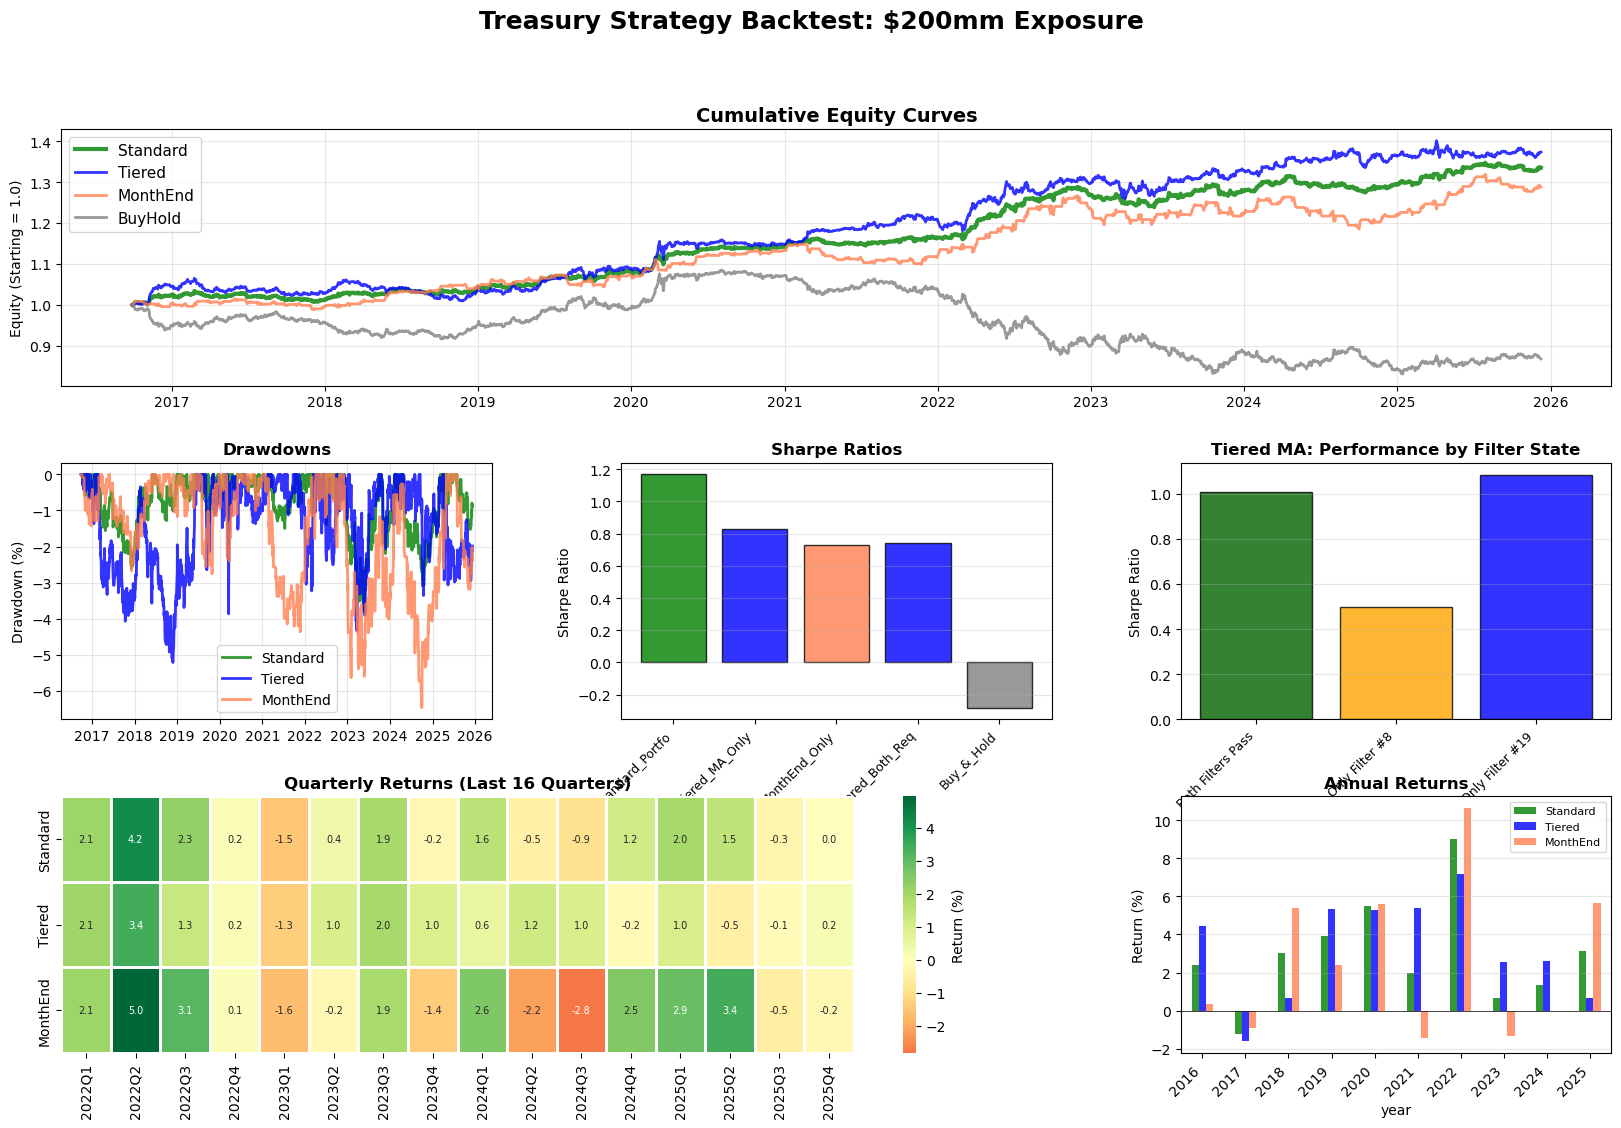

In [5]:
"""
TREASURY FUTURES STRATEGY - STANDALONE BACKTEST MODULE - MONTH END IS CORRECTLY LINED UP
=====================================================

Standard Portfolio: 50% Tiered MA Cross + 50% Month-End Long/Short
Total Exposure: $200mm (configurable)

Author: Quantitative Research Team
Date: December 2025
"""

import pandas as pd
import numpy as np
from xbbg import blp
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Date range
YEARS_BACK = 10  # Default: 10 years of history
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=365 * YEARS_BACK)

# Exposure and allocation
TOTAL_EXPOSURE_MM = 200  # Total portfolio exposure in $mm
TIERED_ALLOCATION = 0.50  # 50% to Tiered MA, 50% to MonthEnd
MONTHEND_ALLOCATION = 1.0 - TIERED_ALLOCATION

# Derived allocations
TIERED_BASE_MM = TOTAL_EXPOSURE_MM * TIERED_ALLOCATION
MONTHEND_BASE_MM = TOTAL_EXPOSURE_MM * MONTHEND_ALLOCATION

print("="*80)
print("TREASURY FUTURES STRATEGY BACKTEST")
print("="*80)
print(f"\nConfiguration:")
print(f"  Date Range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"  Total Exposure: ${TOTAL_EXPOSURE_MM}mm")
print(f"  Tiered MA Allocation: {TIERED_ALLOCATION*100:.0f}% (${TIERED_BASE_MM}mm)")
print(f"  MonthEnd Allocation: {MONTHEND_ALLOCATION*100:.0f}% (${MONTHEND_BASE_MM}mm)")

# ============================================================================
# STEP 1: DATA ACQUISITION
# ============================================================================
print("\n" + "="*80)
print("STEP 1: DATA ACQUISITION")
print("="*80)

print("\nFetching TY1 Comdty (10Y Treasury Futures)...")

try:
    ty_data = blp.bdh(
        tickers='TY1 Comdty',
        flds=['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'PX_VOLUME'],
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    ty_data.columns = ['_'.join(col).strip() for col in ty_data.columns.values]
    ty_data.columns = ['open', 'high', 'low', 'close', 'volume']
    
    print(f"  ✓ TY data: {len(ty_data)} observations")
    print(f"  ✓ Date range: {ty_data.index[0]} to {ty_data.index[-1]}")
    
except Exception as e:
    print(f"  ✗ Error: {e}")
    raise

print("\nFetching SPX Index (for correlation filter)...")

try:
    spx_data = blp.bdh(
        tickers='SPX Index',
        flds='PX_LAST',
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    spx_data.columns = ['spx_close']
    
    print(f"  ✓ SPX data: {len(spx_data)} observations")
    
except Exception as e:
    print(f"  ✗ Error: {e}")
    raise

# Merge data
data = pd.concat([ty_data, spx_data], axis=1).fillna(method='ffill')

print(f"\n  Combined dataset: {len(data)} observations")
print(f"  Missing values: {data.isnull().sum().sum()}")

# ============================================================================
# STEP 2: CALCULATE INDICATORS
# ============================================================================
print("\n" + "="*80)
print("STEP 2: CALCULATING INDICATORS")
print("="*80)

# Price and returns
data['price'] = data['close']
data['returns'] = data['price'].pct_change()

# Moving averages
data['ma_20'] = data['price'].rolling(20).mean()
data['ma_50'] = data['price'].rolling(50).mean()
data['ma_200'] = data['price'].rolling(200).mean()

# SPX returns and correlation
data['spx_returns'] = data['spx_close'].pct_change()
data['ty_spx_corr_20d'] = data['returns'].rolling(20).corr(data['spx_returns'])

print(f"  ✓ Moving averages calculated (20, 50, 200-day)")
print(f"  ✓ TY/SPX correlation calculated (20-day rolling)")

# Clean data
data_clean = data.dropna()
print(f"  ✓ Clean data: {len(data_clean)} observations (after removing NaN)")

# ============================================================================
# STEP 3: STRATEGY SIGNALS
# ============================================================================
print("\n" + "="*80)
print("STEP 3: GENERATING STRATEGY SIGNALS")
print("="*80)

# === TIERED MA CROSS ===
print("\nTiered MA Cross 20/50...")

# Base direction
signal_ma_direction = pd.Series(0, index=data_clean.index)
signal_ma_direction[data_clean['ma_20'] > data_clean['ma_50']] = 1  # Bullish
signal_ma_direction[data_clean['ma_20'] < data_clean['ma_50']] = -1  # Bearish

# Filter conditions
filter_8 = (abs(data_clean['price'] - data_clean['ma_20']) / data_clean['price']) >= 0.001
filter_19 = data_clean['ty_spx_corr_20d'] <= 0

# Tiered exposure (in $mm)
tiered_exposure_mm = pd.Series(0.0, index=data_clean.index)

both_pass = filter_8 & filter_19
one_passes = (filter_8 & ~filter_19) | (~filter_8 & filter_19)
neither_pass = ~filter_8 & ~filter_19

tiered_exposure_mm[both_pass] = TIERED_BASE_MM * 1.0  # 100% of allocation
tiered_exposure_mm[one_passes] = TIERED_BASE_MM * 0.5  # 50% of allocation
tiered_exposure_mm[neither_pass] = 0.0  # 0% of allocation

# Apply direction
tiered_exposure_mm = tiered_exposure_mm * signal_ma_direction

# Alternative: Both filters required
tiered_exposure_both_required = pd.Series(0.0, index=data_clean.index)
tiered_exposure_both_required[both_pass] = TIERED_BASE_MM * signal_ma_direction[both_pass]

print(f"  ✓ Tiered signals generated")
print(f"    Both filters: {both_pass.sum()} days")
print(f"    One filter:   {one_passes.sum()} days")
print(f"    No filters:   {neither_pass.sum()} days")

# Breakdown by individual filter
only_8 = filter_8 & ~filter_19
only_19 = ~filter_8 & filter_19

print(f"    Only Filter #8: {only_8.sum()} days")
print(f"    Only Filter #19: {only_19.sum()} days")

# === MONTH-END LONG/SHORT ===
print("\nMonth-End Long/Short...")

def create_month_end_exposure(dates, base_mm):
    """Create month-end exposure in $mm"""
    # Ensure dates is DatetimeIndex
    if not isinstance(dates, pd.DatetimeIndex):
        dates = pd.DatetimeIndex(dates)
    
    df = pd.DataFrame({'date': dates, 'ym': dates.to_period('M')})
    exposure = pd.Series(0.0, index=dates)
    
    for ym in df['ym'].unique():
        month_mask = df['ym'] == ym
        month_idx = df[month_mask].index
        
        if len(month_idx) >= 5:
            # Long last 5 days
            exposure.iloc[month_idx[-5:]] = base_mm
            # Short first 5 days
            exposure.iloc[month_idx[:5]] = -base_mm
    
    return exposure

monthend_exposure_mm = create_month_end_exposure(data_clean.index, MONTHEND_BASE_MM)

long_days = (monthend_exposure_mm > 0).sum()
short_days = (monthend_exposure_mm < 0).sum()
flat_days = (monthend_exposure_mm == 0).sum()

print(f"  ✓ MonthEnd signals generated")
print(f"    Long days:  {long_days}")
print(f"    Short days: {short_days}")
print(f"    Flat days:  {flat_days}")

# === BUY & HOLD BENCHMARK ===
buyhold_exposure_mm = pd.Series(TOTAL_EXPOSURE_MM, index=data_clean.index)

print(f"\n  ✓ Buy & Hold benchmark (${TOTAL_EXPOSURE_MM}mm always long)")

print("\n" + "="*80)
print("Ready for Step 4: Return Calculation")
print("="*80)

print("\nSignals generated for:")
print("  - Standard Portfolio (Tiered + MonthEnd)")
print("  - Tiered MA only (with filter analysis)")
print("  - Tiered Both-Required (stricter version)")
print("  - MonthEnd only")
print("  - Buy & Hold benchmark")

# ============================================================================
# STEP 4: CALCULATE DOLLAR P&L
# ============================================================================
print("\n" + "="*80)
print("STEP 4: CALCULATING DOLLAR P&L")
print("="*80)

print("\n⚠️ IMPORTANT TIMING DIFFERENCE:")
print("  MA Strategy: Signal(t) shifted → Return(t+1) [reactive]")
print("  MonthEnd: Signal(t) → Return(t) [pre-announced, no shift]")

# Standard Portfolio components
# Tiered uses shift(1) - reactive to MAs
tiered_pnl_daily = tiered_exposure_mm.shift(1) * data_clean['returns']

# MonthEnd NO shift - positions set day ahead since knowable
monthend_pnl_daily = monthend_exposure_mm * data_clean['returns']

# Combined
standard_pnl_daily = tiered_pnl_daily + monthend_pnl_daily

# Individual strategies for comparison
# Tiered Both-Required (also uses shift)
tiered_both_pnl_daily = tiered_exposure_both_required.shift(1) * data_clean['returns']

# Buy & Hold (uses shift)
buyhold_pnl_daily = buyhold_exposure_mm.shift(1) * data_clean['returns']

print("  ✓ Standard Portfolio P&L calculated")
print("  ✓ Component P&Ls calculated (Tiered with shift, MonthEnd without)")
print("  ✓ Buy & Hold P&L calculated")

# Convert to percentage returns on base exposure
standard_returns = standard_pnl_daily / TOTAL_EXPOSURE_MM
tiered_returns = tiered_pnl_daily / TIERED_BASE_MM
monthend_returns = monthend_pnl_daily / MONTHEND_BASE_MM
tiered_both_returns = tiered_both_pnl_daily / TIERED_BASE_MM
buyhold_returns = buyhold_pnl_daily / TOTAL_EXPOSURE_MM

# ============================================================================
# STEP 5: BUILD AUDIT DATAFRAME
# ============================================================================
print("\n" + "="*80)
print("STEP 5: BUILDING COMPREHENSIVE AUDIT TRAIL")
print("="*80)

audit = pd.DataFrame(index=data_clean.index)

# Market data
audit['Date'] = audit.index
audit['TY_Close'] = data_clean['price']
audit['TY_Return_%'] = data_clean['returns'] * 100
audit['MA_20'] = data_clean['ma_20']
audit['MA_50'] = data_clean['ma_50']
audit['MA_200'] = data_clean['ma_200']
audit['SPX_Close'] = data_clean['spx_close']
audit['TY_SPX_Corr_20d'] = data_clean['ty_spx_corr_20d']

# Filter states
audit['Filter_8_Pass'] = filter_8.astype(int)
audit['Filter_19_Pass'] = filter_19.astype(int)
audit['Filters_Count'] = filter_8.astype(int) + filter_19.astype(int)

# Tiered signals
audit['Tiered_Direction'] = signal_ma_direction
audit['Tiered_Exposure_$mm'] = tiered_exposure_mm
audit['Tiered_PnL_$mm'] = tiered_pnl_daily
audit['Tiered_Return_%'] = tiered_returns * 100

# MonthEnd signals
audit['MonthEnd_Exposure_$mm'] = monthend_exposure_mm
audit['MonthEnd_PnL_$mm'] = monthend_pnl_daily
audit['MonthEnd_Return_%'] = monthend_returns * 100

# Standard Portfolio
audit['Standard_Exposure_$mm'] = standard_exposure
audit['Standard_PnL_$mm'] = standard_pnl_daily
audit['Standard_Return_%'] = standard_returns * 100

# Cumulative metrics
audit['Standard_Equity'] = (1 + standard_returns).cumprod()
audit['Tiered_Equity'] = (1 + tiered_returns).cumprod()
audit['MonthEnd_Equity'] = (1 + monthend_returns).cumprod()
audit['BuyHold_Equity'] = (1 + buyhold_returns).cumprod()

# Drawdowns
for strat in ['Standard', 'Tiered', 'MonthEnd', 'BuyHold']:
    cum = audit[f'{strat}_Equity']
    dd = (cum - cum.expanding().max()) / cum.expanding().max()
    audit[f'{strat}_DD_%'] = dd * 100

print(f"  ✓ Audit trail created: {audit.shape[0]} rows × {audit.shape[1]} columns")

# ============================================================================
# STEP 6: FILTER STATE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STEP 6: TIERED MA FILTER STATE ANALYSIS")
print("="*80)

def analyze_filter_state(condition, state_name):
    """Analyze performance in specific filter state"""
    # Shift and fill NaN to avoid indexing issues
    condition_shifted = condition.shift(1).fillna(False)
    state_returns = tiered_returns[condition_shifted]
    
    if len(state_returns) == 0:
        return None
    
    days = condition.sum()
    ann_ret = state_returns.mean() * 252
    ann_vol = state_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    win_rate = (state_returns > 0).sum() / len(state_returns)
    
    return {
        'State': state_name,
        'Days': days,
        'Pct_Days': days / len(condition) * 100,
        'Ann_Return_%': ann_ret * 100,
        'Ann_Vol_%': ann_vol * 100,
        'Sharpe': sharpe,
        'Win_Rate_%': win_rate * 100
    }

filter_states = [
    (both_pass, 'Both Filters Pass'),
    (only_8, 'Only Filter #8'),
    (only_19, 'Only Filter #19'),
    (neither_pass, 'Neither Pass')
]

filter_analysis = []
for condition, name in filter_states:
    result = analyze_filter_state(condition, name)
    if result:
        filter_analysis.append(result)

filter_df = pd.DataFrame(filter_analysis)

print(f"\n{'Filter State':<20s} {'Days':>6s} {'%Days':>7s} {'AnnRet':>8s} {'AnnVol':>8s} {'Sharpe':>7s} {'WinRate':>8s}")
print("-"*80)

for _, row in filter_df.iterrows():
    print(f"{row['State']:<20s} {row['Days']:>6.0f} {row['Pct_Days']:>6.1f}% "
          f"{row['Ann_Return_%']:>7.2f}% {row['Ann_Vol_%']:>7.2f}% "
          f"{row['Sharpe']:>7.2f} {row['Win_Rate_%']:>7.1f}%")

# ============================================================================
# STEP 7: AGGREGATE TO MONTHLY/QUARTERLY/ANNUAL
# ============================================================================
print("\n" + "="*80)
print("STEP 7: AGGREGATING PERFORMANCE PERIODS")
print("="*80)

def calc_period_aggregates(returns_series, period_type='M'):
    """Aggregate daily returns to monthly/quarterly/annual"""
    # Ensure index is DatetimeIndex
    if not isinstance(returns_series.index, pd.DatetimeIndex):
        returns_series.index = pd.DatetimeIndex(returns_series.index)
    
    df = pd.DataFrame({'ret': returns_series})
    df['year'] = returns_series.index.year
    
    if period_type == 'M':
        df['month'] = returns_series.index.month
        grouped = df.groupby(['year', 'month'])
        period_returns = grouped['ret'].apply(lambda x: (1+x).prod()-1)
        period_returns.index = pd.to_datetime([f"{y}-{m:02d}-01" for y, m in period_returns.index])
    elif period_type == 'Q':
        df['quarter'] = returns_series.index.quarter
        grouped = df.groupby(['year', 'quarter'])
        period_returns = grouped['ret'].apply(lambda x: (1+x).prod()-1)
        period_returns.index = [f"{y}Q{q}" for y, q in period_returns.index]
    else:  # Annual
        period_returns = df.groupby('year')['ret'].apply(lambda x: (1+x).prod()-1)
    
    return period_returns

# Monthly
monthly_standard = calc_period_aggregates(standard_returns, 'M')
monthly_tiered = calc_period_aggregates(tiered_returns, 'M')
monthly_monthend = calc_period_aggregates(monthend_returns, 'M')
monthly_tiered_both = calc_period_aggregates(tiered_both_returns, 'M')
monthly_buyhold = calc_period_aggregates(buyhold_returns, 'M')

# Quarterly
quarterly_standard = calc_period_aggregates(standard_returns, 'Q')
quarterly_tiered = calc_period_aggregates(tiered_returns, 'Q')
quarterly_monthend = calc_period_aggregates(monthend_returns, 'Q')
quarterly_tiered_both = calc_period_aggregates(tiered_both_returns, 'Q')
quarterly_buyhold = calc_period_aggregates(buyhold_returns, 'Q')

# Annual
annual_standard = calc_period_aggregates(standard_returns, 'Y')
annual_tiered = calc_period_aggregates(tiered_returns, 'Y')
annual_monthend = calc_period_aggregates(monthend_returns, 'Y')
annual_tiered_both = calc_period_aggregates(tiered_both_returns, 'Y')
annual_buyhold = calc_period_aggregates(buyhold_returns, 'Y')

print(f"  ✓ Monthly returns: {len(monthly_standard)} months")
print(f"  ✓ Quarterly returns: {len(quarterly_standard)} quarters")
print(f"  ✓ Annual returns: {len(annual_standard)} years")

# ============================================================================
# STEP 8: COMPREHENSIVE PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("STEP 8: CALCULATING PERFORMANCE METRICS")
print("="*80)

def calc_comprehensive_metrics(returns_series, name, exposure_mm):
    """Calculate full suite of performance metrics"""
    ret = returns_series.dropna()
    
    # Basic returns
    total_ret = (1 + ret).prod() - 1
    years = len(ret) / 252
    ann_ret = (1 + total_ret) ** (1/years) - 1
    ann_vol = ret.std() * np.sqrt(252)
    
    # Risk-adjusted
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    downside = ret[ret < 0]
    down_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / down_vol if down_vol > 0 else 0
    
    # Drawdown
    cum = (1 + ret).cumprod()
    dd = (cum - cum.expanding().max()) / cum.expanding().max()
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    # Win metrics
    win_rate = (ret > 0).sum() / len(ret)
    avg_win = ret[ret > 0].mean() if (ret > 0).any() else 0
    avg_loss = ret[ret < 0].mean() if (ret < 0).any() else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    # Dollar metrics
    total_pnl_mm = total_ret * exposure_mm
    ann_pnl_mm = ann_ret * exposure_mm
    
    return {
        'Strategy': name,
        'Exposure_$mm': exposure_mm,
        'Total_Return_%': total_ret * 100,
        'Total_PnL_$mm': total_pnl_mm,
        'Annual_Return_%': ann_ret * 100,
        'Annual_PnL_$mm': ann_pnl_mm,
        'Annual_Vol_%': ann_vol * 100,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD_%': max_dd * 100,
        'Calmar': calmar,
        'Win_Rate_%': win_rate * 100,
        'Avg_Win_%': avg_win * 100,
        'Avg_Loss_%': avg_loss * 100,
        'Profit_Factor': profit_factor,
        'Total_Days': len(ret)
    }

metrics = [
    calc_comprehensive_metrics(standard_returns, 'Standard_Portfolio', TOTAL_EXPOSURE_MM),
    calc_comprehensive_metrics(tiered_returns, 'Tiered_MA_Only', TIERED_BASE_MM),
    calc_comprehensive_metrics(monthend_returns, 'MonthEnd_Only', MONTHEND_BASE_MM),
    calc_comprehensive_metrics(tiered_both_returns, 'Tiered_Both_Required', TIERED_BASE_MM),
    calc_comprehensive_metrics(buyhold_returns, 'Buy_&_Hold', TOTAL_EXPOSURE_MM)
]

metrics_df = pd.DataFrame(metrics)

print("\nPerformance Summary:")
print(f"\n{'Strategy':<25s} {'Sharpe':>7s} {'AnnRet':>8s} {'Ann$mm':>8s} {'MaxDD':>8s}")
print("-"*65)

for _, row in metrics_df.iterrows():
    print(f"{row['Strategy']:<25s} {row['Sharpe']:>7.2f} {row['Annual_Return_%']:>7.2f}% "
          f"${row['Annual_PnL_$mm']:>7.1f}mm {row['Max_DD_%']:>7.2f}%")

# ============================================================================
# STEP 9: EXPORT TO EXCEL
# ============================================================================
print("\n" + "="*80)
print("STEP 9: EXPORTING COMPREHENSIVE EXCEL FILE")
print("="*80)

filename = f'Treasury_20_50_MA_Month_End_Lagged_Backtest_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xlsx'

with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
    
    # Sheet 1: Configuration & Documentation
    config_df = pd.DataFrame({
        'Parameter': ['Start Date', 'End Date', 'Total Exposure', 'Tiered Allocation', 
                     'MonthEnd Allocation', 'Tiered Base $mm', 'MonthEnd Base $mm'],
        'Value': [START_DATE.strftime('%Y-%m-%d'), END_DATE.strftime('%Y-%m-%d'),
                 f'${TOTAL_EXPOSURE_MM}mm', f'{TIERED_ALLOCATION*100:.0f}%',
                 f'{MONTHEND_ALLOCATION*100:.0f}%', f'${TIERED_BASE_MM}mm', f'${MONTHEND_BASE_MM}mm']
    })
    config_df.to_excel(writer, sheet_name='Configuration', index=False)
    
    # Sheet 2: Strategy Documentation
    strategy_doc = pd.DataFrame({
        'Strategy': ['Standard Portfolio', 'Tiered MA Cross', 'MonthEnd Long/Short'],
        'Description': [
            '50% Tiered MA + 50% MonthEnd - Combined portfolio',
            'MA 20/50 cross with tiered exposure: $100mm both filters, $50mm one filter, $0mm neither',
            'Long last 5 days ($100mm), Short first 5 days ($100mm)'
        ],
        'Exposure_Logic': [
            'Sum of component exposures',
            'Both filters: $100mm | One filter: $50mm | Neither: $0mm',
            'Active periods: $100mm | Inactive: $0mm'
        ]
    })
    strategy_doc.to_excel(writer, sheet_name='Strategy_Documentation', index=False)
    
    # Sheet 3: Daily Audit Trail
    audit.to_excel(writer, sheet_name='Daily_Audit_Trail', index=False)
    
    # Sheet 4: Performance Metrics
    metrics_df.to_excel(writer, sheet_name='Performance_Metrics', index=False)
    
    # Sheet 5: Filter State Analysis
    filter_df.to_excel(writer, sheet_name='Filter_State_Analysis', index=False)
    
    # Sheet 6-10: Monthly returns
    monthly_comparison = pd.DataFrame({
        'Standard_%': monthly_standard * 100,
        'Tiered_%': monthly_tiered * 100,
        'MonthEnd_%': monthly_monthend * 100,
        'Tiered_Both_%': monthly_tiered_both * 100,
        'BuyHold_%': monthly_buyhold * 100
    })
    monthly_comparison.to_excel(writer, sheet_name='Monthly_Returns')
    
    # Monthly dollar P&L
    monthly_pnl = pd.DataFrame({
        'Standard_$mm': monthly_standard * TOTAL_EXPOSURE_MM,
        'Tiered_$mm': monthly_tiered * TIERED_BASE_MM,
        'MonthEnd_$mm': monthly_monthend * MONTHEND_BASE_MM,
        'Tiered_Both_$mm': monthly_tiered_both * TIERED_BASE_MM,
        'BuyHold_$mm': monthly_buyhold * TOTAL_EXPOSURE_MM
    })
    monthly_pnl.to_excel(writer, sheet_name='Monthly_PnL_$mm')
    
    # Sheet 11-15: Quarterly
    quarterly_comparison = pd.DataFrame({
        'Standard_%': quarterly_standard * 100,
        'Tiered_%': quarterly_tiered * 100,
        'MonthEnd_%': quarterly_monthend * 100,
        'Tiered_Both_%': quarterly_tiered_both * 100,
        'BuyHold_%': quarterly_buyhold * 100
    })
    quarterly_comparison.to_excel(writer, sheet_name='Quarterly_Returns')
    
    quarterly_pnl = pd.DataFrame({
        'Standard_$mm': quarterly_standard * TOTAL_EXPOSURE_MM,
        'Tiered_$mm': quarterly_tiered * TIERED_BASE_MM,
        'MonthEnd_$mm': quarterly_monthend * MONTHEND_BASE_MM,
        'Tiered_Both_$mm': quarterly_tiered_both * TIERED_BASE_MM,
        'BuyHold_$mm': quarterly_buyhold * TOTAL_EXPOSURE_MM
    })
    quarterly_pnl.to_excel(writer, sheet_name='Quarterly_PnL_$mm')
    
    # Sheet 16-20: Annual
    annual_comparison = pd.DataFrame({
        'Standard_%': annual_standard * 100,
        'Tiered_%': annual_tiered * 100,
        'MonthEnd_%': annual_monthend * 100,
        'Tiered_Both_%': annual_tiered_both * 100,
        'BuyHold_%': annual_buyhold * 100
    })
    annual_comparison.to_excel(writer, sheet_name='Annual_Returns')
    
    annual_pnl = pd.DataFrame({
        'Standard_$mm': annual_standard * TOTAL_EXPOSURE_MM,
        'Tiered_$mm': annual_tiered * TIERED_BASE_MM,
        'MonthEnd_$mm': annual_monthend * MONTHEND_BASE_MM,
        'Tiered_Both_$mm': annual_tiered_both * TIERED_BASE_MM,
        'BuyHold_$mm': annual_buyhold * TOTAL_EXPOSURE_MM
    })
    annual_pnl.to_excel(writer, sheet_name='Annual_PnL_$mm')

print(f"  ✓ Excel file created: {filename}")
print(f"  ✓ Total sheets: 12")

# ============================================================================
# STEP 10: GENERATE CHARTS
# ============================================================================
print("\n" + "="*80)
print("STEP 10: GENERATING VISUALIZATIONS")
print("="*80)

# Chart 1: Main Performance Dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle(f'Treasury Strategy Backtest: ${TOTAL_EXPOSURE_MM}mm Exposure', 
             fontsize=18, fontweight='bold')

# Equity curves
ax1 = fig.add_subplot(gs[0, :])
colors = {'Standard': 'green', 'Tiered': 'blue', 'MonthEnd': 'coral', 
          'Tiered_Both': 'purple', 'BuyHold': 'gray'}
lws = {'Standard': 3, 'Tiered': 2, 'MonthEnd': 2, 'Tiered_Both': 2, 'BuyHold': 2}

for col in ['Standard', 'Tiered', 'MonthEnd', 'BuyHold']:
    audit[f'{col}_Equity'].plot(ax=ax1, label=col.replace('_', ' '), 
                                color=colors[col], linewidth=lws[col], alpha=0.8)

ax1.set_title('Cumulative Equity Curves', fontweight='bold', fontsize=14)
ax1.set_ylabel('Equity (Starting = 1.0)')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Drawdowns
ax2 = fig.add_subplot(gs[1, 0])
for col in ['Standard', 'Tiered', 'MonthEnd']:
    audit[f'{col}_DD_%'].plot(ax=ax2, label=col, color=colors[col], linewidth=2, alpha=0.8)
ax2.set_title('Drawdowns', fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Sharpe comparison
ax3 = fig.add_subplot(gs[1, 1])
sharpes = metrics_df.set_index('Strategy')['Sharpe']
bars = ax3.bar(range(len(sharpes)), sharpes, 
              color=[colors.get(s.split('_')[0], 'gray') for s in sharpes.index],
              alpha=0.8, edgecolor='black')
ax3.set_xticks(range(len(sharpes)))
ax3.set_xticklabels([s[:15] for s in sharpes.index], rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Sharpe Ratios', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Filter state performance
ax4 = fig.add_subplot(gs[1, 2])
filter_df_plot = filter_df[filter_df['State'] != 'Neither Pass'].copy()
x = range(len(filter_df_plot))
bars = ax4.bar(x, filter_df_plot['Sharpe'], alpha=0.8, edgecolor='black',
              color=['darkgreen', 'orange', 'blue'])
ax4.set_xticks(x)
ax4.set_xticklabels(filter_df_plot['State'], rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Tiered MA: Performance by Filter State', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Quarterly returns heatmap
ax5 = fig.add_subplot(gs[2, :2])
quarterly_heatmap = pd.DataFrame({
    'Standard': quarterly_standard * 100,
    'Tiered': quarterly_tiered * 100,
    'MonthEnd': quarterly_monthend * 100
}).T

sns.heatmap(quarterly_heatmap.iloc[:, -16:], annot=True, fmt='.1f', cmap='RdYlGn',
           center=0, linewidths=1, ax=ax5, cbar_kws={'label': 'Return (%)'},
           annot_kws={'fontsize': 7})
ax5.set_title('Quarterly Returns (Last 16 Quarters)', fontweight='bold')

# Annual returns
ax6 = fig.add_subplot(gs[2, 2])
annual_comparison = pd.DataFrame({
    'Standard': annual_standard * 100,
    'Tiered': annual_tiered * 100,
    'MonthEnd': annual_monthend * 100
})
annual_comparison.plot(kind='bar', ax=ax6, color=['green', 'blue', 'coral'], alpha=0.8)
ax6.set_title('Annual Returns', fontweight='bold')
ax6.set_ylabel('Return (%)')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3, axis='y')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
chart1_file = filename.replace('.xlsx', '_Dashboard.png')
plt.savefig(chart1_file, dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: {chart1_file}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("BACKTEST COMPLETE")
print("="*80)

print(f"\n📊 STANDARD PORTFOLIO (${TOTAL_EXPOSURE_MM}mm exposure):")
std_metrics = metrics_df[metrics_df['Strategy'] == 'Standard_Portfolio'].iloc[0]
print(f"   Annual Return:  {std_metrics['Annual_Return_%']:>6.2f}%")
print(f"   Annual P&L:     ${std_metrics['Annual_PnL_$mm']:>6.1f}mm")
print(f"   Sharpe Ratio:   {std_metrics['Sharpe']:>7.2f}")
print(f"   Max Drawdown:   {std_metrics['Max_DD_%']:>6.2f}%")
print(f"   Win Rate:       {std_metrics['Win_Rate_%']:>6.1f}%")

print(f"\n📁 Files Generated:")
print(f"   Excel: {filename}")
print(f"   Chart: {chart1_file}")

print(f"\n📋 Excel Contains {12} Sheets:")
print(f"   1. Configuration - Parameters used")
print(f"   2. Strategy_Documentation - Strategy descriptions")
print(f"   3. Daily_Audit_Trail - Complete daily data")
print(f"   4. Performance_Metrics - Comprehensive statistics")
print(f"   5. Filter_State_Analysis - Tiered MA by filter state")
print(f"   6. Monthly_Returns - Monthly % returns")
print(f"   7. Monthly_PnL_$mm - Monthly dollar P&L")
print(f"   8. Quarterly_Returns - Quarterly % returns")
print(f"   9. Quarterly_PnL_$mm - Quarterly dollar P&L")
print(f"   10. Annual_Returns - Annual % returns")
print(f"   11. Annual_PnL_$mm - Annual dollar P&L")

print("\n" + "="*80)
print("READY FOR INTERNAL DISTRIBUTION")
print("="*80)

# Display sample results
print("\nQuarterly Returns Sample (Last 8 quarters):")
print(quarterly_comparison.tail(8).to_string())